In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# LOADING DATA

In [37]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
train.head()

test.isna().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Cleaning

In [38]:

train=train.drop(columns=['Ticket','Embarked']) # I think I won't use these data as it may not be correlated with survival (ticket number and place of embarcation)
test=test.drop(columns=['Ticket','Embarked'])
train.describe(include="all")
df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
trainingSetLength = len(train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


We need to :
* Fill the missing Age values : could be a very important feature
* Complete the cabin column : I decided to infer that NaN values in the cabin column had been used for describing passengers without cabins... (Otherwise, we could simply remove the column)
* Deal  with the missing Fare



In [40]:
## Generating random Ages for missing values using average and std on both train and test sets


age_nullTotal = df['Age'].isna().sum()
avgAge = df['Age'].mean()
stdAge = df['Age'].std()
rdmAges  = np.random.randint(avgAge - stdAge,avgAge + stdAge, size = age_nullTotal)
ages=df["Age"].copy()
ages[np.isnan(ages)] = rdmAges
df["Age"] = ages

# We predict the missing ages
#col = ['Pclass','SibSp','Parch']
#from sklearn.ensemble import ExtraTreesRegressor as ETRg
#def missingAge(df):
#    mod = ETRg(n_estimators = 200, random_state = 2)
#    X_Train = df[col][df.Age.notnull()]
#    Y_Train = df['Age'][df.Age.notnull()]
#    X_Test = df[col][df.Age.isnull()]
#    
#    mod.fit(X_Train,np.ravel(Y_Train))
#    AgePred = mod.predict(X_Test)
#    df.loc[df.Age.isnull(), 'Age'] = AgePred
#    
#missingAge(df)


In [41]:
df.isna().sum()

Age               0
Cabin          1014
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
title             0
dtype: int64

In [42]:
df.describe(include="all")

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title
count,1309.000000,295,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,18
top,NaN,C23 C25 C27,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,Mr
freq,NaN,6,NaN,2,NaN,NaN,NaN,843,NaN,NaN,757
mean,29.900435,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,13.414393,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.500000,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,38.000000,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


In [43]:
# How to deal with missing cabin values ?
# I decided to infer that NaN values in the cabin column had been used for describing passengers without cabins... Otherwise, we could simply not use the Cabin column for the model
df['Cabin'].fillna(0, inplace=True)
df.loc[df['Cabin'] != 0,"Cabin"] = 1


In [46]:
df["Fare"] = df["Fare"].fillna(df["Fare"].mean()) # only one missing value, so using the mean or median is sufficient

In [44]:
df.isna().sum()
# Missing values for "survived" correspond to the test set NaN values


Age              0
Cabin            0
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
title            0
dtype: int64

# Data Exploration and Engineering

In [39]:
# Getting the titles
df["title"] = pd.Series([line.split(",")[1].split()[0].strip(".") for line in df["Name"]])
print(df["title"].value_counts())


Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
the           1
Lady          1
Jonkheer      1
Capt          1
Dona          1
Sir           1
Mme           1
Name: title, dtype: int64


In [48]:
# Grouping the titles in a new variable
nonRareTitles = ["Mr","Miss","Mrs","Master"]
df["title"] = df["title"].apply(lambda x: ('RareTitle' if x not in nonRareTitles else x))
df["title"] = df["title"].map({"Master":0,     "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1,     "Mr":2, "RareTitle":3})

In [45]:
# Mapping the gender
sexMap = {'female':0,'male':1}
df['Sex'] = df['Sex'].map(sexMap)

In [47]:
df.head(20)

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title
0,22.0,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,Mr
1,38.0,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,Mrs
2,26.0,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,Miss
3,35.0,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,Mrs
4,35.0,0,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,Mr
5,43.0,0,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,Mr
6,54.0,1,51.8625,"McCarthy, Mr. Timothy J",0,7,1,1,0,0.0,Mr
7,2.0,0,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0.0,Master
8,27.0,0,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1.0,Mrs
9,14.0,0,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1.0,Mrs


In [49]:
#separate train and test sets
train = df[:trainingSetLength].copy()
test = df[trainingSetLength:].copy()


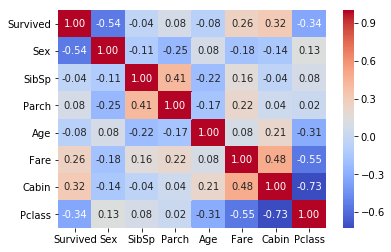

In [50]:
g = sns.heatmap(train[["Survived","Sex","SibSp","Parch","Age","Fare","Cabin","Pclass"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

We observe a correlation between Survival and Sex, Fare, Cabin and Pclass.
We can't find a strong correlation between Survival and the other features.

As we could expect, there is a correlation between Fare and Cabin (more expensive to rent a cabin...) and between Age and Cabin (older people tend to be richer and need more comfort)

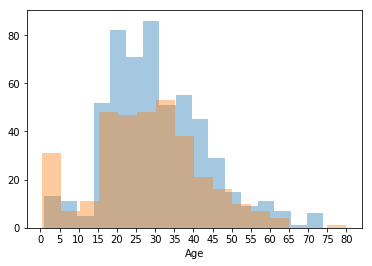

In [51]:
g1= sns.distplot(train["Age"][train["Survived"] == 0], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Age of the deceased")
g1.set(xticks=range(0,100,5))
g2=sns.distplot(train["Age"][train["Survived"] == 1], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Age of survivors")

Babies and children were the first saved ! --> see the hump around 5 years. 
There is also a decrease of the number of survivors older than 60 years old. Notice that the mdeian value for both distributions is almost the same.
Age seems to be a very important feature, but we did not find any correlation between age and Survival at first.

We could maybe increase the importance of the feature by grouping the people by age (see below)

In [52]:
train.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title
0,22.0,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,2
1,38.0,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,1
2,26.0,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,1
3,35.0,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,1
4,35.0,0,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,2


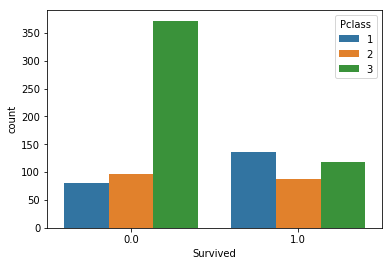

In [53]:
sns.countplot(data=train,x='Survived',hue='Pclass')


Rich people (or at least upper class) are more likely to survive... Maybe there had priority during evacuation.
Pclass is also an important feature for the future model

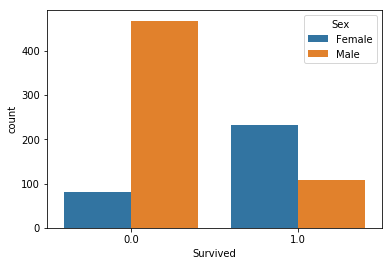

In [54]:
c = sns.countplot(data=train,x='Survived',hue='Sex')
new_labels = ['Female', 'Male']
leg = c.axes.get_legend()
for te, la in zip(leg.texts, new_labels): te.set_text(la)


Women and girls are more likely to survive...

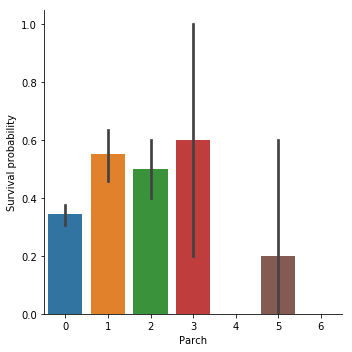

In [55]:
c2 = sns.factorplot(x="Parch",y="Survived",data=train, kind='bar')
c2 = c2.set_ylabels("Survival probability")

Difficult to conclude with the high standard deviation, bu it seems that small families (1 or 2 Parch) are more likely to survive

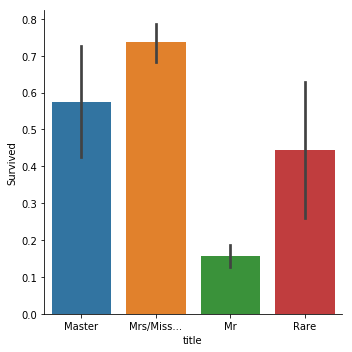

In [56]:
c3 = sns.factorplot(x="title",y="Survived",data=train, kind='bar')
c3 = c3.set_xticklabels(["Master","Mrs/Miss...","Mr","Rare"])
c2 = c2.set_ylabels("Survival probability")

A large proportion of the people from the rareTitle group were rescued. As we saw earlier, women are more likely to be saved than men from the "Mr" group.

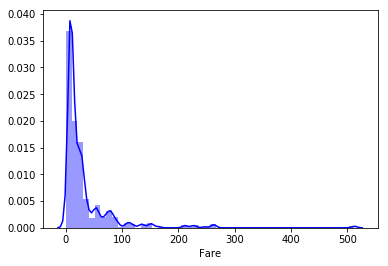

In [57]:
d= sns.distplot(train["Fare"], color="blue")

This feature will be very difficult to use because of the distortion towards lower values.
Therefore we apply a log transformation, before scaling

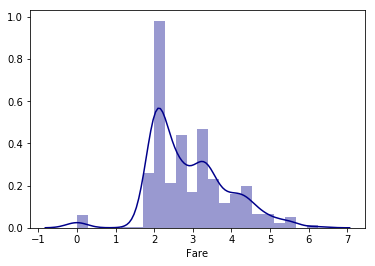

In [58]:
# Transform the fare distribution
train["Fare"] = train["Fare"].transform(lambda x: ( 0 if x<=0 else np.log(x)))
d_transformed= sns.distplot(train["Fare"], color="darkBlue")
test["Fare"] = test["Fare"].transform(lambda x: ( 0 if x<=0 else np.log(x)))

This is a possibility. But finally I decided to create a new feature "Fare groups" (see below)

### Age groups

In [59]:
def age_groups(age):
    a = ''
    if age <= 5:
        a = 0
    elif age <= 17:
        a = 1
    elif age <= 28:
        a = 2
    elif age <= 45:
        a = 3
    elif age <= 65:
        a = 4
    else:
        a = 5
    return a
df['ageGroup'] = df['Age'].map(age_groups)



### Family size

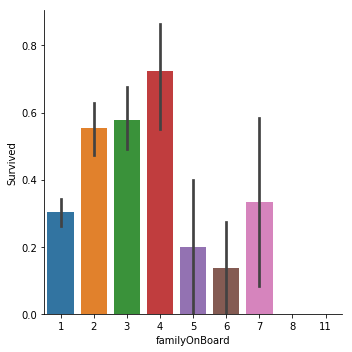

In [60]:
# Create new feature of family size
df["familyOnBoard"] = df["SibSp"]+df["Parch"]+1
sns.factorplot(x="familyOnBoard",y="Survived",data=df, kind='bar')

I decided to create 3 groups :

In [61]:
df['Single'] = df['familyOnBoard'].map(lambda s: 1 if s == 1 else 0)
df['SmallFamily'] = df['familyOnBoard'].map(lambda s: 1 if s in [2, 3,4] else 0)
df['LargeFamily'] = df['familyOnBoard'].map(lambda s: 1 if s >=5 else 0)
df.drop(['familyOnBoard'],axis=1,inplace=True)

### Fare Ranges

In [62]:
df['FareRange']=pd.qcut(df['Fare'],4)
print(df['FareRange'])
df['FareCat']=0
df.loc[df['Fare']<=7.9,'FareCat']=0
df.loc[(df['Fare']>7.9)&(df['Fare']<=14.5),'FareCat']=1
df.loc[(df['Fare']>14.5)&(df['Fare']<=31),'FareCat']=2
df.loc[(df['Fare']>31)&(df['Fare']<=513),'FareCat']=3
df.drop(['FareRange'],axis=1,inplace=True)


0         (-0.001, 7.896]
1       (31.275, 512.329]
2         (7.896, 14.454]
3       (31.275, 512.329]
4         (7.896, 14.454]
              ...        
1304      (7.896, 14.454]
1305    (31.275, 512.329]
1306      (-0.001, 7.896]
1307      (7.896, 14.454]
1308     (14.454, 31.275]
Name: FareRange, Length: 1309, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.896] < (7.896, 14.454] < (14.454, 31.275] < (31.275, 512.329]]


In [63]:
df.drop(['Name','Fare','Age','Parch','SibSp'],axis=1,inplace=True)
# should we drop cabins ? a lot of passengers have more htan 1 cabin...

In [64]:
df = pd.get_dummies(df,columns=['title'], drop_first=True)
df = pd.get_dummies(df,columns=['Pclass'], drop_first=True)
df = pd.get_dummies(df,columns=['ageGroup'], drop_first=True)
df = pd.get_dummies(df,columns=['FareCat'], drop_first=True)
df = pd.get_dummies(df,columns=['Sex'], drop_first=True)
df = pd.get_dummies(df,columns=['Cabin'], drop_first=True)
#df = pd.get_dummies(df,columns=['Parch'], drop_first=True)
#df = pd.get_dummies(df,columns=['SibSp'], drop_first=True)
df.head()

,PassengerId,Survived,Single,SmallFamily,LargeFamily,title_1,title_2,title_3,Pclass_2,Pclass_3,ageGroup_1,ageGroup_2,ageGroup_3,ageGroup_4,ageGroup_5,FareCat_1,FareCat_2,FareCat_3,Sex_1,Cabin_1
0,1,0.0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
1,2,1.0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2,3,1.0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
3,4,1.0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1
4,5,0.0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


MODELLING

In [65]:
#separate train and test sets
data = df[:trainingSetLength].copy()
testData = df[trainingSetLength:].copy()

In [67]:
Y_train = data["Survived"]
X_train = data.drop(labels = ["Survived"],axis = 1)
X_train = X_train.drop(labels = ["PassengerId"],axis = 1)
Y_test = testData["Survived"]
X_test = testData.drop(labels = ["Survived"],axis = 1)
X_test = X_test.drop(labels = ["PassengerId"],axis = 1)


In [68]:
X_train.describe()

,Single,SmallFamily,LargeFamily,title_1,title_2,title_3,Pclass_2,Pclass_3,ageGroup_1,ageGroup_2,ageGroup_3,ageGroup_4,ageGroup_5,FareCat_1,FareCat_2,FareCat_3,Sex_1,Cabin_1
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.602694,0.327722,0.069585,0.344557,0.580247,0.030303,0.206510,0.551066,0.095398,0.351291,0.388328,0.106622,0.008979,0.262626,0.237935,0.249158,0.647587,0.228956
std,0.489615,0.469646,0.254589,0.475490,0.493796,0.171516,0.405028,0.497665,0.293929,0.477642,0.487644,0.308805,0.094383,0.440308,0.426058,0.432769,0.477990,0.420397
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## HyperParameter Tuning using a grid

In [69]:
model=RandomForestClassifier(n_jobs=-1)
grid = { 'criterion':['gini'],
        'min_samples_leaf' : [1,2],
        'max_depth' : [4,5,6],
        'max_features' : ["auto",3,4,5],
        'min_samples_split': [ 6,8,10,12],
        'n_estimators' : [300,400,500,600,700] }

gscv = GridSearchCV(estimator=model,param_grid = grid, cv=5, scoring = 'accuracy',n_jobs=-1,verbose=3)
gscv = gscv.fit(X_train,Y_train)




Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 21.7min finished


In [70]:
print(gscv.cv_results_)
print(gscv.best_score_)
print(gscv.best_params_)

{'mean_fit_time': array([1.20161438, 1.54535928, 1.93930826, 2.30977535, 2.59016876,
       1.14470963, 1.53142052, 1.89383883, 2.29169888, 2.70250034,
       1.23232002, 1.5370625 , 1.86807275, 2.2906177 , 2.61699634,
       1.14152236, 1.54454937, 1.93244905, 2.28776326, 2.73061609,
       1.15033517, 1.68604398, 2.12689648, 2.27330108, 2.63094697,
       1.17158308, 1.5482204 , 1.88514018, 2.29331002, 2.64186177,
       1.17062354, 1.55789876, 1.92265329, 2.29681268, 2.6000948 ,
       1.16285291, 1.56576414, 1.90648389, 2.26742592, 2.62434974,
       1.15198674, 1.51181993, 1.95946169, 2.27436318, 2.8614625 ,
       1.16592994, 1.58847771, 1.90456424, 2.22901378, 2.59727445,
       1.15329661, 1.52363338, 1.88187599, 2.19026856, 2.62471352,
       1.14343834, 1.53253384, 1.90004964, 2.20124984, 2.57024984,
       1.15791306, 1.493927  , 1.88075056, 2.22470303, 2.65098224,
       1.15203266, 1.53486853, 2.11405368, 2.27062945, 2.61860261,
       1.14892664, 1.47404943, 1.86732693, 2

In [75]:
#ok ?
model_final = RandomForestClassifier(criterion='gini', 
                             n_estimators=300,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             max_depth = 6,
                             max_features = 'auto',
                             oob_score=True,
                             random_state=12,
                             n_jobs=-1)
model_final.fit(X_train,Y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=12, verbose=0,
                       warm_start=False)

In [76]:
print(model_final.oob_score_)

0.8249158249158249


In [ ]:
kfold = KFold(n_splits=6, random_state=10) # 

xyz=[]
accuracy=[]
std=[]
cv_result = cross_val_score(model_final,X_train,Y_train, cv = kfold,scoring = "accuracy")
xyz=cv_result.mean()
std=cv_result.std()
accuracy=cv_result
print(accuracy,xyz,std)

In [ ]:
importances = model_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_final.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

feature_importances = pd.DataFrame(model_final.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance' , ascending=False)
print(feature_importances)

In [ ]:
X_train.describe()

# Submission

In [ ]:
predict = model_final.predict(testData.drop(labels = ["Survived","PassengerId"],axis = 1))
submission = pd.DataFrame({'PassengerId':testData['PassengerId'],'Survived':predict.astype(int)})
print(predict.astype(int))
filename = 'Prediction.csv'
submission.to_csv(filename,index=False)
